Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Fine-Tuning
:label:`sec_fine_tuning`

In earlier chapters, we discussed how to train models on the Fashion-MNIST training dataset with only 60000 images. We also described ImageNet, the most widely used large-scale image dataset in academia, which has more than 10 million images and 1000 objects. However, the size of the dataset that we usually encounter is between those of the two datasets.


Suppose that we want to recognize different types of chairs from images, and then recommend purchase links to users. 
One possible method is to first identify
100 common chairs,
take 1000 images of different angles for each chair, 
and then train a classification model on the collected image dataset.
Although this chair dataset may be larger than the Fashion-MNIST dataset,
the number of examples is still less than one-tenth of 
that in ImageNet.
This may lead to overfitting of complicated models 
that are suitable for ImageNet on this chair dataset.
Besides, due to the limited amount of training examples,
the accuracy of the trained model
may not meet practical requirements.


In order to address the above problems,
an obvious solution is to collect more data.
However, collecting and labeling data can take a lot of time and money.
For example, in order to collect the ImageNet dataset, researchers have spent millions of dollars from research funding.
Although the current data collection cost has been significantly reduced, this cost still cannot be ignored.


Another solution is to apply *transfer learning* to transfer the knowledge learned from the *source dataset* to the *target dataset*.
For example, although most of the images in the ImageNet dataset have nothing to do with chairs, the model trained on this dataset may extract more general image features, which can help identify edges, textures, shapes, and object composition.
These similar features may
also be effective for recognizing chairs.


## Steps


In this section, we will introduce a common technique in transfer learning: *fine-tuning*. As shown in :numref:`fig_finetune`, fine-tuning consists of the following four steps:


1. Pretrain a neural network model, i.e., the *source model*, on a source dataset (e.g., the ImageNet dataset).
1. Create a new neural network model, i.e., the *target model*. This copies all model designs and their parameters on the source model except the output layer. We assume that these model parameters contain the knowledge learned from the source dataset and this knowledge will also be applicable to the target dataset. We also assume that the output layer of the source model is closely related to the labels of the source dataset; thus it is not used in the target model.
1. Add an output layer to the target model, whose number of outputs is the number of categories in the target dataset. Then randomly initialize the model parameters of this layer.
1. Train the target model on the target dataset, such as a chair dataset. The output layer will be trained from scratch, while the parameters of all the other layers are fine-tuned based on the parameters of the source model.

![Fine tuning.](../img/finetune.svg)
:label:`fig_finetune`

When target datasets are much smaller than source datasets, fine-tuning helps to improve models' generalization ability.


## Hot Dog Recognition

Let's demonstrate fine-tuning via a concrete case:
hot dog recognition. 
We will fine-tune a ResNet model on a small dataset,
which was pretrained on the ImageNet dataset.
This small dataset consists of
thousands of images with and without hot dogs.
We will use the fine-tuned model to recognize 
hot dogs from images.


In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### Reading the Dataset

[**The hot dog dataset we use was taken from online images**].
This dataset consists of
1400 positive-class images containing hot dogs,
and as many negative-class images containing other foods.
1000 images of both classes are used for training and the rest are for testing.


After unzipping the downloaded dataset,
we obtain two folders `hotdog/train` and `hotdog/test`. Both folders have `hotdog` and `not-hotdog` subfolders, either of which contains images of
the corresponding class.


In [2]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

We create two instances to read all the image files in the training and testing datasets, respectively.


In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

The first 8 positive examples and the last 8 negative images are shown below. As you can see, [**the images vary in size and aspect ratio**].


In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

During training, we first crop a random area of random size and random aspect ratio from the image,
and then scale this area
to a $224 \times 224$ input image. 
During testing, we scale both the height and width of an image to 256 pixels, and then crop a central $224 \times 224$ area as input.
In addition, 
for the three RGB (red, green, and blue) color channels
we *standardize* their values channel by channel.
Concretely,
the mean value of a channel is subtracted from each value of that channel and then the result is divided by the standard deviation of that channel.

[~~Data augmentations~~]


In [5]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### [**Defining and Initializing the Model**]

We use ResNet-18, which was pretrained on the ImageNet dataset, as the source model. Here, we specify `pretrained=True` to automatically download the pretrained model parameters. 
If this model is used for the first time,
Internet connection is required for download.


In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/home/d2l-worker/miniconda3/envs/d2l-en-release-0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/d2l-worker/miniconda3/envs/d2l-en-release-0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The pretrained source model instance contains a number of feature layers and an output layer `fc`.
The main purpose of this division is to facilitate the fine-tuning of model parameters of all layers but the output layer. The member variable `fc` of source model is given below.


In [7]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

As a fully connected layer, it transforms ResNet's final global average pooling outputs into 1000 class outputs of the ImageNet dataset.
We then construct a new neural network as the target model. It is defined in the same way as the pretrained source model except that
its number of outputs in the final layer
is set to
the number of classes in the target dataset (rather than 1000).

In the code below, the model parameters before the output layer of the target model instance `finetune_net` are initialized to model parameters of the corresponding layers from the source model.
Since these model parameters were obtained via pretraining on ImageNet, 
they are effective.
Therefore, we can only use 
a small learning rate to *fine-tune* such pretrained parameters.
In contrast, model parameters in the output layer are randomly initialized and generally require a larger learning rate to be learned from scratch.
Letting the base learning rate be $\eta$, a learning rate of $10\eta$ will be used to iterate the model parameters in the output layer.


In [8]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

### [**Fine-Tuning the Model**]

First, we define a training function `train_fine_tuning` that uses fine-tuning so it can be called multiple times.


In [9]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

We [**set the base learning rate to a small value**]
in order to *fine-tune* the model parameters obtained via pretraining. Based on the previous settings, we will train the output layer parameters of the target model from scratch using a learning rate ten times greater.


loss 0.200, train acc 0.923, test acc 0.940
1025.3 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


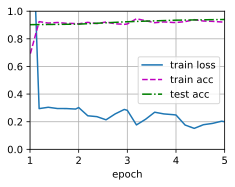

In [10]:
train_fine_tuning(finetune_net, 5e-5)

[**For comparison,**] we define an identical model, but (**initialize all of its model parameters to random values**). Since the entire model needs to be trained from scratch, we can use a larger learning rate.


In [11]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

loss 0.515, train acc 0.797, test acc 0.826
1574.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


As we can see, the fine-tuned model tends to perform better for the same epoch
because its initial parameter values are more effective.


## Summary

* Transfer learning transfers knowledge learned from the source dataset to the target dataset. Fine-tuning is a common technique for transfer learning.
* The target model copies all model designs with their parameters from the source model except the output layer, and fine-tunes these parameters based on the target dataset. In contrast, the output layer of the target model needs to be trained from scratch.
* Generally, fine-tuning parameters uses a smaller learning rate, while training the output layer from scratch can use a larger learning rate.


## Exercises

1. Keep increasing the learning rate of `finetune_net`. How does the accuracy of the model change?
2. Further adjust hyperparameters of `finetune_net` and `scratch_net` in the comparative experiment. Do they still differ in accuracy?
3. Set the parameters before the output layer of `finetune_net` to those of the source model and do *not* update them during training. How does the accuracy of the model change? You can use the following code.


In [12]:
for param in finetune_net.parameters():
    param.requires_grad = False

4. In fact, there is a "hotdog" class in the `ImageNet` dataset. Its corresponding weight parameter in the output layer can be obtained via the following code. How can we leverage this weight parameter?


In [13]:
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape

torch.Size([1, 512])

[Discussions](https://discuss.d2l.ai/t/1439)
